In [1]:
# Import and Load Config

import sys
sys.path.append(".")

import torch 

from omegaconf import OmegaConf

from dmm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    # model.cpu()
    model.eval()
    return model

# Download the ckpt file at: gs://asm-ai-data/Michael/Misc/station.ckpt

def get_model(config, ckpt):
    config = OmegaConf.load(config)  
    model = load_model_from_config(config,ckpt)
    return model

In [3]:
# Load Model and Sampler

# from dmm.models.diffusion.ddim import DDIMSampler
from dmm.models.diffusion.pmls import PLMSSampler

config = "/home/hu/audio-diffusion/configs/cond_1.5.yaml"
ckpt = "/home/hu/audio-diffusion/station.ckpt"
model = get_model(config, ckpt)
sampler = PLMSSampler(model) # TODO: Modify this for the uncond model

Loading model from /home/hu/audio-diffusion/station.ckpt


/home/hu/miniconda3/envs/th/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v1.10.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.15.self_attn.out_proj.weight', 'vision_model.encoder.layers.20.self_attn.k_proj.bias', 'vision_model.encoder.layers.23.self_attn.out_proj.weight', 'vision_model.encoder.layers.14.self_attn.out_proj.weight', 'vision_model.encoder.layers.20.layer_norm1.bias', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'vision_model.encoder.layers.17.mlp.fc2.weight', 'vision_model.encoder.layers.14.layer_norm1.weight', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.13.mlp.fc1.weight', 'vision_model.encoder.layers.8.self_attn.out_proj.bias', 'vision_model.encoder.layers.17.self_attn.v_proj.bias', 'vision_model.enc

Restored from v1-5-pruned.ckpt with 0 missing and 688 unexpected keys


In [4]:
# Generate Spectrum

import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

n_samples_per_class = 1

ddim_steps = 15
ddim_eta = 0.0


# prompts = ["slow, relax, ambient, sleep"]
prompts = ["guitar, classic"]

uc = model.get_learned_conditioning(n_samples_per_class * [""])
c = model.get_learned_conditioning(prompts)
all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=n_samples_per_class,
                                            shape=[4, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=5, # 3.5
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)

rendering 1 examples in 15 steps
Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 16 timesteps


PLMS Sampler: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]


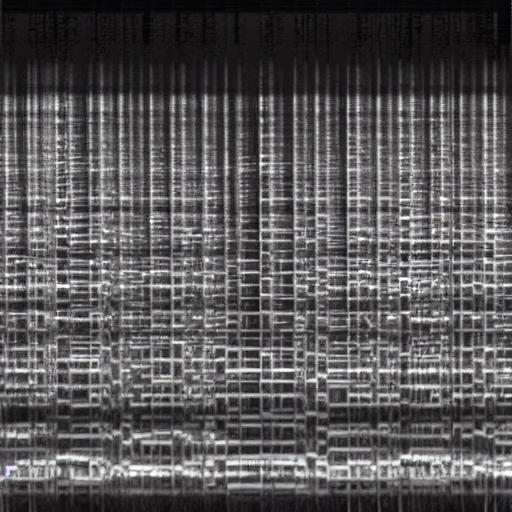

In [5]:
# Plot Spectrum

g = (x_samples_ddim[0] * 255.).cpu().numpy().transpose(1, 2, 0)
Image.fromarray(g.astype(np.uint8))

In [7]:
# Spec to Wav

from IPython.display import Audio
from dmm.util import waveform_from_tensor
aud = waveform_from_tensor(x_samples_ddim[0])
display(Audio(aud, rate=44100))